In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, leastsq
import scipy.io
import os
import h5py

from natsort import natsorted
from scipy.ndimage import binary_fill_holes, binary_dilation, binary_erosion

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider, fixed

import nibabel as nib

from scipy.ndimage import gaussian_filter

import SimpleITK as sitk

import time

## DATASETS

In [2]:
# DataSet 1 - Final resize in 3D 1/PhaseResolution
#FSE_Images = imresize(ifft2c(KSpace_noise), [size(KSpace,1), round(size(KSpace,2)/PhaseResolution)]);
#Images_crop = imresize3(FSE_Images,1/PhaseResolution); 0.7
data_set = '26w_no_motion_AX_no_shift_202311161901'

In [8]:
# DataSet 2 - Final resize in 3D 1/PhaseOversampling

#FSE_Images = imresize(ifft2c(KSpace_noise), [size(KSpace,1), round(size(KSpace,2)/PhaseResolution)]);
#Images_crop = imresize3(FSE_Images,1/PhaseOversampling); 0.8011
data_set = '26w_no_motion_AX_no_shift_202311162155'

In [14]:
# DataSet 3 - No Resize

#FSE_Images = imresize(ifft2c(KSpace_noise), [size(KSpace,1), round(size(KSpace,2)/PhaseResolution)]);
#Images_crop = FSE_Images
data_set = '26w_no_motion_AX_no_shift_202311162220'

## DATA IMPORT

In [15]:
# import FaBIAN output .mat file and get TEeff of each scan
# variables:
#  - t2w_images = 4d numpy array of dimensions (x,y,slice,necho)
#  - TEeffs = 



#no motion
path_dir = '/Users/margauxroulet/Desktop/MIAL/Data/FaBIAN/Haste_1_5T_no_motion/'
path = path_dir + data_set
data_folder = os.listdir(path)

# Exclude .DS_Store file if it exists
ds_store_file = '.DS_Store'
if ds_store_file in data_folder:
    data_folder.remove(ds_store_file)

# Create hdf5_files list
hdf5_files = [h5py.File(os.path.join(path, data), 'r') for data in data_folder]

# Define a custom sorting key function
def get_numeric_part(file):
    return int(file.filename.split('Brain_')[1].split('_')[0]) # make it more robust to end date

# Sort the list based on numerical order within filenames and extract TEeffs
hdf5_files = sorted(hdf5_files, key=get_numeric_part)
TEeffs = np.array([get_numeric_part(file) for file in hdf5_files])

# Create an empty list to store 3D arrays
array_list = []

# Load each HDF5 file and append the 'FSE_Images' array to the list
for file in hdf5_files:
    fse_images = file['Images_crop'][:]
    ref_t2map = file['ref_T2map'][:]
    fse_images = np.transpose(fse_images, (2, 1, 0)) # as matlab is col-major and numpy row-major
    ref_t2map = np.transpose(ref_t2map, (2, 1, 0))
    fse_images = np.array(fse_images['real'] + 1j * fse_images['imag'])
    fse_images = np.abs(fse_images)
    array_list.append(fse_images)

    #TEeffs.append(file['TEeff'][:]) # get echo time

# Convert the list of 3D arrays to a 4D array
t2w = np.stack(array_list, axis=-1)

print(f"Dimensions of the simulated t2w images: {t2w.shape} (x,y,slice,necho)")
print(f"Dimensions of the isotropic reference T2map: {ref_t2map.shape}")
print(f"TEeffs: {TEeffs}")

Dimensions of the simulated t2w images: (135, 189, 48, 4) (x,y,slice,necho)
Dimensions of the isotropic reference T2map: (135, 189, 155)
TEeffs: [159 205 251 298]


## MASK

In [16]:
# Build a 4D mask 

# Initialize the 4D output array
threshold = 1.0 # for sufficient signal
masks_4d = np.zeros(t2w.shape, dtype=np.uint8)

# Iterate over scans with different echo time
for j in range(masks_4d.shape[3]):
    # Iterate over slices
    for i in range(masks_4d.shape[2]):
        # Read the binary image
        BW = t2w[:,:,i,j] > threshold
        BW = binary_fill_holes(BW)
        BW = binary_dilation(BW, structure=np.ones((5, 5)))
        BW = binary_erosion(BW, structure=np.ones((5, 5)))

        # Store the result in the 4D array
        masks_4d[:, :, i, j] = BW

mask = np.sum(masks_4d,axis=3) > 0

## MONO-EXPONENTIAL FITTING

In [17]:
# T2 mapping - mono-exponential fit - version with for loop

# Define the exponential decay function
def exponential_decay(t, A, T2, C):
    return A * np.exp(-t / T2) + C


# Initial guess and boundaries for the parameters
initial_guess = [200, 70, 0.05]
param_bounds = ([0, 0, 0], [1000, 2000, 0.2])

# reshape for computation time
reshaped_t2w = np.reshape(t2w, (-1, TEeffs.size))
reshaped_mask = np.reshape(mask, (-1, 1))

# Initialize an array to store the fitting parameters for each voxel
t2map = np.zeros_like(reshaped_t2w[..., 0])

mask_indices, _ = np.where(reshaped_mask)
starttime = time.time()
for voxel in mask_indices:
    
    # take only voxel intensity > 1
    idx = reshaped_t2w[voxel,:] > 1
    # Iterate over the masked indices and fit the exponential decay model (method: non-linear least square)
    params, _ = curve_fit(exponential_decay, TEeffs, reshaped_t2w[voxel,:], p0=initial_guess, bounds = param_bounds)
    # Extract the T2 values from the fitted parameters
    t2map[voxel] = params[1]

t2map = np.reshape(t2map, (t2w.shape[0],t2w.shape[1],t2w.shape[2]))
print(f"Time to fit (mono-exponential): {round(time.time()-starttime,2)} sec")

Time to fit (mono-exponential): 343.39 sec


In [18]:
# Build an anisotropic resampled_ref_t2map based on t2map anisotropic volume
# dim: ref_t2map 135x189x155  -->  resampled_ref_t2map: 135x189x48

vectorized_t2map = t2map.reshape((-1, t2map.shape[2]))
vectorized_ref_t2map = ref_t2map.reshape((-1,  ref_t2map.shape[2]))
vectorized_mask = mask.reshape(-1,mask.shape[2])

resampled_ref_t2map = np.zeros_like(vectorized_t2map)

ds_factor = ref_t2map.shape[2]/t2map.shape[2]
sl_th = int(np.floor(ds_factor/2))
# iterate slice
for slice in range(vectorized_t2map.shape[1]):
    sl_c = int(round((slice+0.5)*ds_factor))
    resampled_ref_t2map[:,slice] = np.mean(vectorized_ref_t2map[:,sl_c-sl_th:sl_c+sl_th], axis=1)

resampled_ref_t2map = np.reshape(resampled_ref_t2map,t2map.shape)

# Build a mask for the resampled ref t2map
ref_t2map_mask = np.zeros_like(resampled_ref_t2map)

# Iterate over slices
for i in range(masks_4d.shape[2]):
        # Read the binary image
        BW = resampled_ref_t2map[:,:,i] > threshold
        BW = binary_fill_holes(BW)
        BW = binary_dilation(BW, structure=np.ones((3, 3)))
        BW = binary_erosion(BW, structure=np.ones((3, 3)))

        # Store the result in the 4D array
        ref_t2map_mask[:, :, i] = BW


In [139]:
# to quantify error, evaluate where t2 values was computed (ref to mask) 
# and evaluate only for resampled_ref-t2map !=0
reshaped_resampled_ref_t2map = np.reshape(resampled_ref_t2map,(-1,1))
reshaped_t2map = np.reshape(t2map,(-1,1))
err_matrix = np.zeros_like(reshaped_t2map)

ref_mask_indices,_ = np.where(reshaped_resampled_ref_t2map > 0)

for voxel in ref_mask_indices:
        err_matrix[voxel] = np.abs((reshaped_resampled_ref_t2map[voxel] - reshaped_t2map[voxel])/reshaped_resampled_ref_t2map[voxel])

err_matrix = np.reshape(err_matrix,t2map.shape)

## DATA EXPORT

In [19]:
# save data as .nii.gz images

# Voxel sizes in millimeters (replace these with your actual voxel sizes)
voxel_sizes = (1.101, 1.101, 3.2)

# Create an affine matrix with identity rotation and translations
affine_matrix = np.eye(4)

# Set the voxel sizes along the diagonal (first three elements of the first three rows)
affine_matrix[0, 0] = voxel_sizes[0]
affine_matrix[1, 1] = voxel_sizes[1]
affine_matrix[2, 2] = voxel_sizes[2]

# Optionally, set the origin or translations (adjust these based on your image)
affine_matrix[0, 3] = -0.5 * voxel_sizes[0] * t2map.shape[0]
affine_matrix[1, 3] = -0.5 * voxel_sizes[1] * t2map.shape[1]
affine_matrix[2, 3] = -0.5 * voxel_sizes[2] * t2map.shape[2]


# Voxel sizes in millimeters (replace these with your actual voxel sizes)
voxel_sizes2 = (1.1, 1.1, 1)

# Create an affine matrix with identity rotation and translations
affine_matrix2 = np.eye(4)

# Set the voxel sizes along the diagonal (first three elements of the first three rows)
affine_matrix2[0, 0] = voxel_sizes2[0]
affine_matrix2[1, 1] = voxel_sizes2[1]
affine_matrix2[2, 2] = voxel_sizes2[2]

# Optionally, set the origin or translations (adjust these based on your image)
affine_matrix2[0, 3] = -0.5 * voxel_sizes2[0] * ref_t2map.shape[0]
affine_matrix2[1, 3] = -0.5 * voxel_sizes2[1] * ref_t2map.shape[1]
affine_matrix2[2, 3] = -0.5 * voxel_sizes2[2] * ref_t2map.shape[2]


# Create a NIfTI image from the NumPy array
nifti_image_t2map =          nib.Nifti1Image(t2map, affine_matrix)  # Assuming identity affine matrix
nifti_image_mask =           nib.Nifti1Image(mask.astype(float), affine_matrix)  # Assuming identity affine matrix
nifti_image_ref_t2map =      nib.Nifti1Image(resampled_ref_t2map, affine_matrix)  # Assuming identity affine matrix
nifti_image_ref_t2map_mask = nib.Nifti1Image(ref_t2map_mask.astype(float), affine_matrix)  # Assuming identity affine matrix
nifti_image_ref_t2map_in =   nib.Nifti1Image(ref_t2map, affine_matrix2)  # Assuming identity affine matrix

# Save the NIfTI image to a file
path_dir_out = '/Users/margauxroulet/Desktop/MIAL/Data/t2mapping/Haste_1_5T_no_motion/'
output_file_path = path_dir_out + data_set +'/t2map.nii.gz'  # Provide the desired output file path
nib.save(nifti_image_t2map, output_file_path)
output_file_path = path_dir_out + data_set +'/t2map_mask.nii.gz'  # Provide the desired output file path
nib.save(nifti_image_mask, output_file_path)
output_file_path = path_dir_out + data_set +'/ref_t2map.nii.gz'  # Provide the desired output file path
nib.save(nifti_image_ref_t2map, output_file_path)
output_file_path = path_dir_out + data_set +'/ref_t2map_mask.nii.gz'  # Provide the desired output file path
nib.save(nifti_image_ref_t2map_mask, output_file_path)
output_file_path = path_dir_out + data_set +'/ref_t2map_in.nii.gz'  # Provide the desired output file path
nib.save(nifti_image_ref_t2map_in, output_file_path)

print(f"NumPy array saved as NIfTI file: {output_file_path}")

NumPy array saved as NIfTI file: /Users/margauxroulet/Desktop/MIAL/Data/t2mapping/Haste_1_5T_no_motion/26w_no_motion_AX_no_shift_202311162220/ref_t2map_in.nii.gz


## Quick Slice Viewer

In [171]:
#volume = t2map
#volume = t2w[:,:,:,3]
#volume = err_matrix
#volume = resampled_ref_t2map
volume = ref_t2map

# Get the global min and max values for the entire volume
global_min = volume.min()
global_max = volume.max()

def show_slice(volume, axis, slice_num):
    fig = plt.figure(figsize=(8, 8))

    if axis == 'xy':
        plt.imshow(volume[:, :, slice_num], cmap='magma', origin='lower', vmin=global_min, vmax=global_max)
        plt.title(f'XY Slice {slice_num}')
    elif axis == 'xz':
        plt.imshow(volume[:, slice_num, :].T, cmap='magma', origin='lower', vmin=global_min, vmax=global_max)
        plt.title(f'XZ Slice {slice_num}')
    elif axis == 'yz':
        plt.imshow(volume[slice_num, :, :].T, cmap='magma', origin='lower', vmin=global_min, vmax=global_max)
        plt.title(f'YZ Slice {slice_num}')


    # Add color scale bar
    cbar = plt.colorbar()
    cbar.set_label('Intensity')

    plt.show()

# Use ipywidgets interact to create an interactive viewer
interact(show_slice, volume=fixed(volume), axis=['xy'], slice_num=IntSlider(min=0, max=volume.shape[2]-1, step=1, value=0))

0.0
2000.0


interactive(children=(Dropdown(description='axis', options=('xy',), value='xy'), IntSlider(value=0, descriptio…

<function __main__.show_slice(volume, axis, slice_num)>

## Quick Mono-exponential fitting evaluation

voxel: 576167
T2 values at TEs : [3.1104827 2.2655656 1.8323468 1.6999586]
Fitted T2: 187.7801277960528


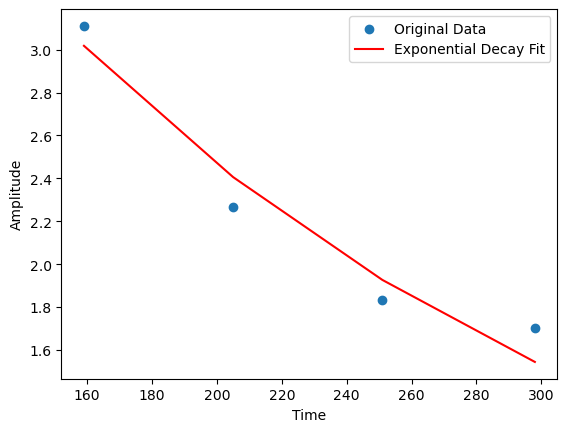

In [281]:
# TEST ONLY ----- T2 mapping with a mono exponential fit

# Define the exponential decay function
def exponential_decay(t, A, T2, C):
    return A * np.exp(-t / T2) + C

# reshape for computation time
reshaped_t2w = np.reshape(t2w, (-1, TEeffs.size))
reshaped_mask = np.reshape(mask, (-1, 1))

mask_indices, _ = np.where(reshaped_mask)

voxel = np.random.choice(mask_indices)
print(f"voxel: {voxel}")
print(f"T2 values at TEs : {reshaped_t2w[voxel,:]}")
idx = reshaped_t2w[voxel,:] > 1
# Perform the exponential decay fit
params, _ = curve_fit(exponential_decay, TEeffs, reshaped_t2w[voxel,:], p0=initial_guess, bounds = param_bounds)

# Extract the fitted parameters
A_fit, T2_fit, C_fit = params

# Print the fitted T2 value
print(f"Fitted T2: {T2_fit}")

# Plot the original data and the fitted curve
plt.scatter(TEeffs[idx], reshaped_t2w[voxel,:][idx], label='Original Data')
plt.plot(TEeffs, exponential_decay(TEeffs, A_fit, T2_fit, C_fit), label='Exponential Decay Fit', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()